In [ ]:
import kagglehub

path = kagglehub.dataset_download("plameneduardo/sarscov2-ctscan-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\cigan\.cache\kagglehub\datasets\plameneduardo\sarscov2-ctscan-dataset\versions\2


In [ ]:
# ==========================================================
# CONFIGURAÇÕES DE AMBIENTE (EVITA MENSAGENS DO TENSORFLOW NO CONSOLE ) 
# ==========================================================
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# ==========================================================
# IMPORTAÇÕES DAS BIBLIOTECAS
# ==========================================================
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D,
    Dropout, BatchNormalization, Input
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import cv2
import kagglehub
from tqdm import tqdm

In [ ]:
# ==========================================================
# DOWNLOAD DATASET + CONFIGURAÇÕES BÁSICAS DOS PARAMETRSO
# ==========================================================
path = kagglehub.dataset_download("plameneduardo/sarscov2-ctscan-dataset")
DATA_PATH = path

CLASSES = ["COVID", "non-COVID"]
IMAGE_SIZE = 64
EPOCHS = 50
BATCH_SIZE = 64
SEED = 42

In [ ]:
# ==========================================================
# CARREGAMENTO DAS IMAGENS
# ==========================================================
data = []
labels = []

for idx, cls in enumerate(CLASSES):
    folder = os.path.join(DATA_PATH, cls)
    for file in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, file))
        if img is not None:
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
            data.append(img)
            labels.append(idx)

X = np.array(data) / 255.0
y = to_categorical(labels, num_classes=2)


In [ ]:
# ==========================================================
# SPLIT ESTRATIFICADO
# ==========================================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=SEED
)

# ==========================================================
# DATA AUGMENTATION (AGORA COM ROTAÇÃO E AFINSS )
# ==========================================================
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

In [ ]:
# ==========================================================
#  DENSENET121
# ==========================================================
base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(2, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# ==========================================================
# COMPILAÇÃO
# ==========================================================
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.002),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ==========================================================
# CALLBACKS
# ==========================================================
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-4)
]

# ==========================================================
# TREINAMENTO
# ==========================================================
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# ==========================================================
# AVALIAÇÃO
# ==========================================================
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"\nVal Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 78s 947ms/step - accuracy: 0.6653 - loss: 0.9506 - val_accuracy: 0.4950 - val_loss: 3458.8015 - learning_rate: 0.0020
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 778ms/step - accuracy: 0.7490 - loss: 0.6363 - val_accuracy: 0.4688 - val_loss: 188.2824 - learning_rate: 0.0020
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 781ms/step - accuracy: 0.7777 - loss: 0.5188 - val_accuracy: 0.7163 - val_loss: 0.7274 - learning_rate: 0.0020
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 700ms/step - accuracy: 0.8236 - loss: 0.4090 - val_accuracy: 0.5936 - val_loss: 0.6978 - learning_rate: 0.0020
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 764ms/step - accuracy: 0.8306 - loss: 0.3909 - val_accuracy: 0.6559 - val_loss: 0.5627 - learning_rate: 0.0020
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 710ms/step - accuracy: 0.8427 - loss: 0.3718 - val_accuracy: 0.8169 - val_loss: 0.4696 - learning_rate: 0.0020
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.8372 - los

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


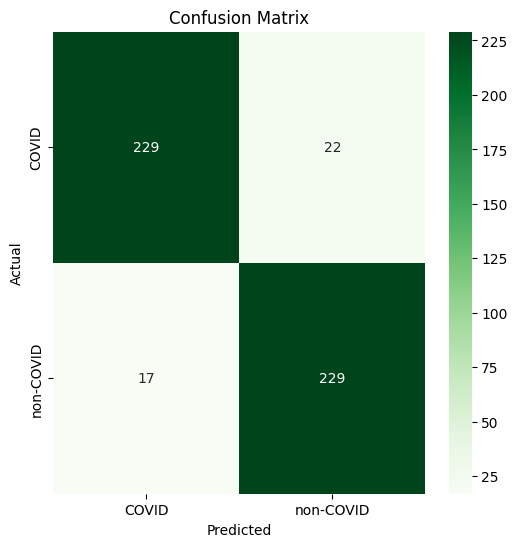

In [20]:
# ==========================================================
# MATRIZ DE CONFUSÃO
# ==========================================================
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASSES,
            yticklabels=CLASSES,
            cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

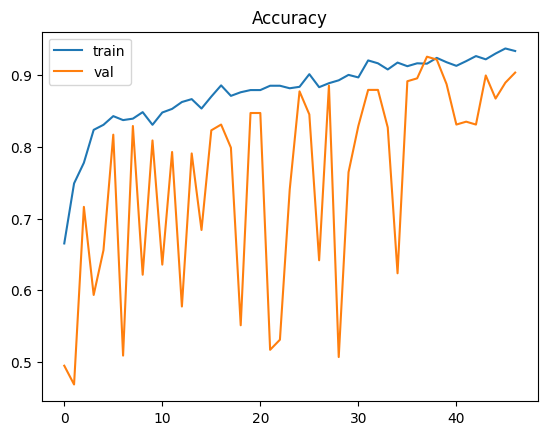

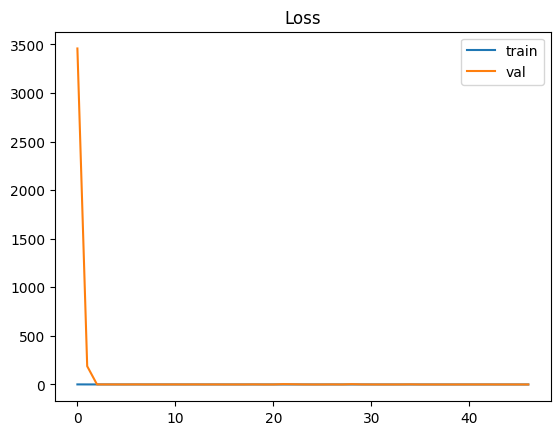

In [21]:
# ==========================================================
# GRÁFICOS
# ==========================================================
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()
plt.show()